In [1]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
import fcalc

## Binarized data

In [2]:
df = pd.read_csv("estonia-passenger-list.csv")

In [3]:
df['Survived'] = [x == 1 for x in df['Survived']]
df.head()

,PassengerId,Country,Firstname,Lastname,Sex,Age,Category,Survived
0,1,Sweden,ARVID KALLE,AADLI,M,62,P,False
1,2,Estonia,LEA,AALISTE,F,22,C,False
2,3,Estonia,AIRI,AAVASTE,F,21,C,False
3,4,Sweden,JURI,AAVIK,M,53,C,False
4,5,Sweden,BRITTA ELISABET,AHLSTROM,F,55,P,False


In [4]:
quartiles = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
age_q = []
for i in quartiles:
    age_q.append(df['Age'].quantile(i))

def quantiles(x):
    for i in age_q:
        if x > i:
            return f'>{i}'

df['Age'] = df['Age'].apply(quantiles)
df.drop(columns = ['PassengerId','Firstname', 'Lastname'], inplace=True)
column_names = df.columns.values[:-1]

df.head()

,Country,Sex,Age,Category,Survived
0,Sweden,M,>55.0,P,False
1,Estonia,F,>0.0,C,False
2,Estonia,F,>0.0,C,False
3,Sweden,M,>49.0,C,False
4,Sweden,F,>49.0,P,False


In [5]:
X = pd.get_dummies(data=df, prefix=column_names).astype(bool)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    X.drop(["Survived"], axis=1), 
                                                    X["Survived"], 
                                                    test_size=0.3, 
                                                    random_state=1337,
                                                    stratify=X["Survived"], 
                                        )

In [7]:
X_train.head()

,Country_Belarus,Country_Canada,Country_Denmark,Country_Estonia,Country_Finland,Country_France,Country_Germany,Country_Great Britain,Country_Latvia,Country_Lithuania,...,Age_>28.0,Age_>33.0,Age_>39.0,Age_>44.0,Age_>49.0,Age_>55.0,Age_>63.0,Age_>69.0,Category_C,Category_P
784,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
36,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
194,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
87,False,False,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
62,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False


In [8]:
X_train_matrix = X_train.values

kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

for i in ['standard', 'standard-support', 'ratio-support']:
    score_accuracy = []
    
    for array1, array2 in kfold.split(X_train_matrix, y_train):   
        x_train_cv = X_train_matrix[array1]
        y_train_cv = np.array(y_train)[list(array1)]

        x_test_cv = X_train_matrix[array2]
        y_test_cv = np.array(y_train)[list(array2)]

        bin_cls = fcalc.classifier.BinarizedBinaryClassifier(x_train_cv, y_train_cv, method=i)
        bin_cls.predict(x_test_cv)
        y_pred_cv = bin_cls.predictions

        score_accuracy.append(accuracy_score(y_test_cv, y_pred_cv))
    
    print(f'{i}: mean: {np.array(score_accuracy).mean()}, max: {max(score_accuracy)}, min: {min(score_accuracy)}')

    
    
bin_cls = fcalc.classifier.BinarizedBinaryClassifier(X_train_matrix, y_train, method='ratio-support')
bin_cls.predict(X_test.values)
y_pred = bin_cls.predictions

print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

accuracy_fcalc = accuracy_score(y_test, y_pred)
f1_fcalc = f1_score(y_test, y_pred)

standard: mean: 0.4175998331769367, max: 0.5, min: 0.3333333333333333
standard-support: mean: 0.4175998331769367, max: 0.5, min: 0.3333333333333333
ratio-support: mean: 0.5852882911062454, max: 0.6086956521739131, min: 0.5683453237410072
0.5521885521885522
0.3316582914572864


## Pattern structures

In [9]:
df = pd.read_csv("estonia-passenger-list.csv")
df['Survived'] = [x == 1 for x in df['Survived']]
df.head()

,PassengerId,Country,Firstname,Lastname,Sex,Age,Category,Survived
0,1,Sweden,ARVID KALLE,AADLI,M,62,P,False
1,2,Estonia,LEA,AALISTE,F,22,C,False
2,3,Estonia,AIRI,AAVASTE,F,21,C,False
3,4,Sweden,JURI,AAVIK,M,53,C,False
4,5,Sweden,BRITTA ELISABET,AHLSTROM,F,55,P,False


In [10]:
df.drop(columns = ['PassengerId','Firstname', 'Lastname'], inplace=True)
column_names = df.columns.values[:-1]

df.head()

,Country,Sex,Age,Category,Survived
0,Sweden,M,62,P,False
1,Estonia,F,22,C,False
2,Estonia,F,21,C,False
3,Sweden,M,53,C,False
4,Sweden,F,55,P,False


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.drop(["Survived"], axis=1), # X
                                                    df["Survived"], # y
                                                    test_size=0.3, # доля от всех записей
                                                    random_state=1337, # зерно
                                                    stratify=X["Survived"], # а это что?
                                        )

In [12]:
X_train_matrix = X_train.values

kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

for i in ['standard', 'standard-support', 'ratio-support']:
    score_accuracy = []
    
    for array1, array2 in kfold.split(X_train_matrix, y_train):   
        x_train_cv = X_train_matrix[array1]
        y_train_cv = np.array(y_train)[list(array1)]

        x_test_cv = X_train_matrix[array2]
        y_test_cv = np.array(y_train)[list(array2)]
        
        pat_cls = fcalc.classifier.PatternBinaryClassifier(x_train_cv, y_train_cv)
        pat_cls.predict(x_test_cv)
        
        y_pred_cv = pat_cls.predictions

        score_accuracy.append(accuracy_score(y_test_cv, y_pred_cv))
    
    print(f'{i}: mean: {np.array(score_accuracy).mean()}, max: {max(score_accuracy)}, min: {min(score_accuracy)}')

standard: mean: 0.7282973621103118, max: 0.7536231884057971, min: 0.6884057971014492
standard-support: mean: 0.7282973621103118, max: 0.7536231884057971, min: 0.6884057971014492
ratio-support: mean: 0.7282973621103118, max: 0.7536231884057971, min: 0.6884057971014492


In [13]:
pat_cls = fcalc.classifier.PatternBinaryClassifier(X_train_matrix, y_train)
pat_cls.predict(X_test.values)

y_pred = pat_cls.predictions

y_pred = [np.random.choice([0,1]) if i == -1 else i for i in y_pred]
accuracy_fcalc_stru = accuracy_score(y_test, y_pred)
f1_fcalc_stru = f1_score(y_test, y_pred)


# Стандартные модели

In [14]:
df = pd.read_csv("estonia-passenger-list.csv")
df.drop(columns = ['PassengerId','Firstname', 'Lastname'], inplace=True)
df.head()

,Country,Sex,Age,Category,Survived
0,Sweden,M,62,P,0
1,Estonia,F,22,C,0
2,Estonia,F,21,C,0
3,Sweden,M,53,C,0
4,Sweden,F,55,P,0


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.drop(["Survived"], axis=1),
                                                    df["Survived"], 
                                                    test_size=0.3, 
                                                    random_state=1337,
                                                    stratify=X["Survived"], 
                                        )

In [16]:
from sklearn.preprocessing import OrdinalEncoder
from scipy import sparse as sp

def prepare_features_for_logic(data: pd.DataFrame, cat_encoder=None):
    
    cat_columns = ["Country", "Sex", "Category"]  
    real_columns = ["Age"]
    
    # categorical features
    
    if cat_encoder is None:
        oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        oe.fit(data[cat_columns])
    else:
        oe = cat_encoder
    
    X_cat = oe.transform(data[cat_columns])
    mapped_cat_values = oe.categories_
    cat_fnames = cat_columns
    
    
    X_real = data[real_columns].values    
    feature_matrix = np.hstack([X_cat, X_real]) # note: `np` for dense Numpy matrices
    
    return feature_matrix, list(cat_fnames) + real_columns, oe, mapped_cat_values

X_train_dense, fnames_dense, encoder, mapped_cat_values = prepare_features_for_logic(X_train)
X_test_dense, _, _, _ = prepare_features_for_logic(X_test, encoder)

In [17]:
X_train

,Country,Sex,Age,Category
784,Sweden,M,61,P
36,Sweden,M,70,P
194,Sweden,M,43,P
87,Estonia,F,33,C
62,Sweden,F,29,C
...,...,...,...,...
78,Sweden,F,66,P
285,Estonia,M,43,C
473,Sweden,M,36,C
662,Sweden,M,50,P


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


clf = DecisionTreeClassifier(max_depth=4, class_weight="balanced").fit(X_train_dense, y_train)
y_pred = clf.predict(X_test_dense)
print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

accuracy_tree = accuracy_score(y_test, y_pred)
f1_tree = f1_score(y_test, y_pred)

0.4024390243902439
0.67003367003367


In [19]:

param_grid = {
    "n_estimators": [10, 50, 100],
    "min_samples_leaf": [1, 2, 3, 5],
    "max_samples": [0.3, None]
}
param_grid

scores = ["f1", "accuracy"]

for score in scores:
    print("# Tuning for %s" % score)
    print()
    # loo = LeaveOneOut()

    clf = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=100, class_weight='balanced_subsample'), 
                       param_grid, scoring=score, verbose=1, cv=3)

    clf.fit(X_train_dense, y_train)

    print("Best params on dev set:")
    print(clf.best_params_)
    
    print("Scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    best_model = clf.best_estimator_
    best_model.fit(X_train_dense, y_train)
    
y_pred = best_model.predict(X_test_dense)
print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

accuracy_forest = accuracy_score(y_test, y_pred)
f1_forest = f1_score(y_test, y_pred)

# Tuning for f1

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params on dev set:
{'max_samples': None, 'min_samples_leaf': 5, 'n_estimators': 50}
Scores on development set:
0.094 (+/-0.082) for {'max_samples': 0.3, 'min_samples_leaf': 1, 'n_estimators': 10}
0.104 (+/-0.096) for {'max_samples': 0.3, 'min_samples_leaf': 1, 'n_estimators': 50}
0.141 (+/-0.078) for {'max_samples': 0.3, 'min_samples_leaf': 1, 'n_estimators': 100}
0.223 (+/-0.071) for {'max_samples': 0.3, 'min_samples_leaf': 2, 'n_estimators': 10}
0.196 (+/-0.072) for {'max_samples': 0.3, 'min_samples_leaf': 2, 'n_estimators': 50}
0.232 (+/-0.037) for {'max_samples': 0.3, 'min_samples_leaf': 2, 'n_estimators': 100}
0.278 (+/-0.040) for {'max_samples': 0.3, 'min_samples_leaf': 3, 'n_estimators': 10}
0.273 (+/-0.103) for {'max_samples': 0.3, 'min_samples_leaf': 3, 'n_estimators': 50}
0.290 (+/-0.057) for {'max_samples': 0.3, 'min_samples_leaf': 3, 'n_estimators': 100}
0.276 (+/-0.004) for {'max_samples': 0

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy import sparse as sp


def prepare_features_for_logreg(data: pd.DataFrame, cat_encoder=None, real_scaler=None):
    cat_columns = ["Country", "Sex", "Category"]  
    real_columns = ["Age"]
    
    # categorical features
    if cat_encoder is None:
        ohe = OneHotEncoder(handle_unknown="ignore")
        ohe.fit(data[cat_columns])
    else:
        ohe = cat_encoder
    X_cat = ohe.transform(data[cat_columns])
    cat_fnames = ohe.get_feature_names_out(cat_columns)
    
    # real-valued features
    if real_scaler is None:
        stsc = StandardScaler()
        stsc.fit(data[real_columns])
    else:
        stsc = real_scaler
    X_real = stsc.transform(data[real_columns])
    feature_matrix = sp.hstack([X_cat, X_real])
    
    return feature_matrix, list(cat_fnames) + real_columns, ohe, stsc

X_train_sparse, fnames_sparse, encoder_sparse, scaler = prepare_features_for_logreg(X_train)
X_test_sparse, _, _, _ = prepare_features_for_logreg(X_test, encoder_sparse, scaler)

X_train_sparse.shape, X_test_sparse.shape

((692, 20), (297, 20))

In [22]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train_sparse, y_train)

KNeighborsClassifier(n_neighbors=1)

In [23]:
y_pred = neigh.predict(X_test_sparse)
print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

accuracy_knn = accuracy_score(y_test, y_pred)
f1_knn = f1_score(y_test, y_pred)

0.3695652173913043
0.8047138047138047


In [24]:
from sklearn.linear_model import LogisticRegression

clf_linear = LogisticRegression(C=0.99, class_weight="balanced", 
                                solver="saga", penalty="l1")
clf_linear.fit(X_train_sparse, y_train)

y_pred = clf_linear.predict(X_test_sparse)

print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

accuracy_log = accuracy_score(y_test, y_pred)
f1_log = f1_score(y_test, y_pred)

0.43661971830985913
0.7306397306397306


In [25]:
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train_dense, y_train)
y_pred = model.predict(X_test_dense)
print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

accuracy_xgb = accuracy_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)

0.33333333333333337
0.8518518518518519


In [26]:
cat_features = ['Country', 'Sex', 'Category']
from catboost import CatBoostClassifier
clf = CatBoostClassifier(
    iterations=10,
    #verbose=5,
)

clf.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
)

y_pred = clf.predict(X_test)
print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

accuracy_cat = accuracy_score(y_test, y_pred)
f1_cat = f1_score(y_test, y_pred)

Learning rate set to 0.214494
0:	learn: 0.5933556	test: 0.5922380	best: 0.5922380 (0)	total: 179ms	remaining: 1.61s
1:	learn: 0.5246754	test: 0.5249431	best: 0.5249431 (1)	total: 190ms	remaining: 760ms
2:	learn: 0.4792607	test: 0.4776181	best: 0.4776181 (2)	total: 230ms	remaining: 536ms
3:	learn: 0.4450254	test: 0.4415624	best: 0.4415624 (3)	total: 261ms	remaining: 392ms
4:	learn: 0.4226601	test: 0.4192153	best: 0.4192153 (4)	total: 272ms	remaining: 272ms
5:	learn: 0.4048254	test: 0.4020445	best: 0.4020445 (5)	total: 283ms	remaining: 189ms
6:	learn: 0.3911149	test: 0.3882804	best: 0.3882804 (6)	total: 302ms	remaining: 129ms
7:	learn: 0.3810541	test: 0.3767408	best: 0.3767408 (7)	total: 340ms	remaining: 85ms
8:	learn: 0.3727249	test: 0.3667592	best: 0.3667592 (8)	total: 374ms	remaining: 41.6ms
9:	learn: 0.3659661	test: 0.3596876	best: 0.3596876 (9)	total: 422ms	remaining: 0us

bestTest = 0.3596875505
bestIteration = 9

0.0
0.8619528619528619


In [27]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

model.fit(X_train_dense, y_train)
y_pred = model.predict(X_test_dense)

print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))


accuracy_bay = accuracy_score(y_test, y_pred)
f1_bay = f1_score(y_test, y_pred)

0.2033898305084746
0.8417508417508418


# Итоги

Accuracy
-------------------
Fcalc_Binarized: 0.55
Tree: 0.67
Log_Reg: 0.73
KNN: 0.8
Fcalc_Structure: 0.82
NaiveB: 0.84
XGB: 0.85
Catboost: 0.86
RandForest: 0.87


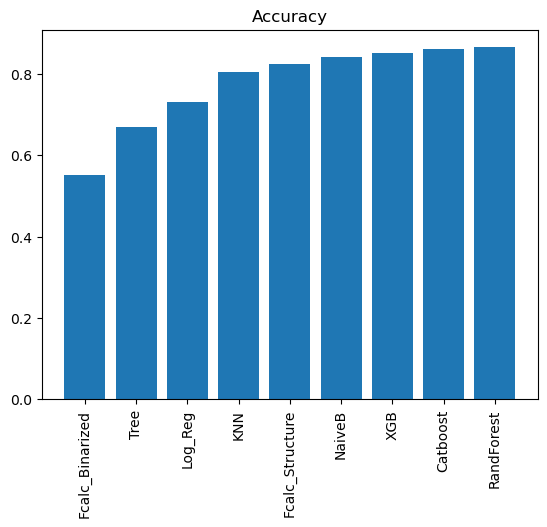

In [28]:
import operator
all_accs = [ accuracy_fcalc
            ,accuracy_fcalc_stru
            ,accuracy_tree
            ,accuracy_forest
            ,accuracy_knn
            ,accuracy_log
            ,accuracy_xgb
            ,accuracy_cat
            ,accuracy_bay]
all_accs_names = [ 
             'Fcalc_Binarized'
            ,'Fcalc_Structure'
            ,'Tree'
            ,'RandForest'
            ,'KNN'
            ,'Log_Reg'
            ,'XGB'
            ,'Catboost'
            ,'NaiveB']

my_dict = dict(zip(all_accs_names, all_accs))
sorted_accs = dict(sorted(my_dict.items(), key=operator.itemgetter(1)))

lists = sorted_accs.items() 
x, y = zip(*lists)

print('Accuracy\n-------------------')
for i in lists:
    print(i[0],': ', round(i[1],2), sep='')
    
plt.bar(x = x, height=y)
plt.xticks(rotation=90)
plt.title('Accuracy');

F1_Score
-------------------
Catboost: 0.0
NaiveB: 0.2
RandForest: 0.26
Fcalc_Binarized: 0.33
XGB: 0.33
Fcalc_Structure: 0.35
KNN: 0.37
Tree: 0.4
Log_Reg: 0.44


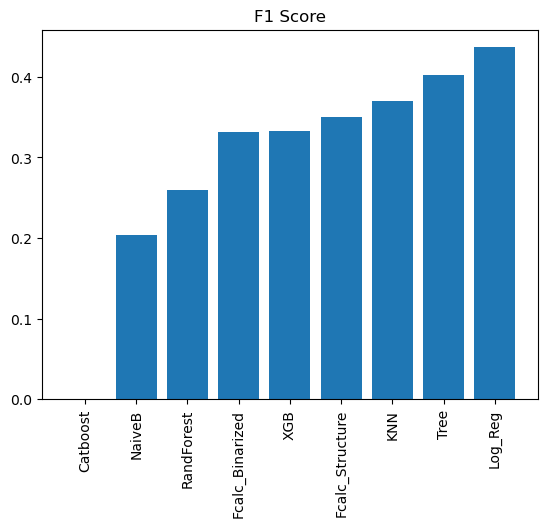

In [29]:
import operator
all_accs = [ f1_fcalc
            ,f1_fcalc_stru
            ,f1_tree
            ,f1_forest
            ,f1_knn
            ,f1_log
            ,f1_xgb
            ,f1_cat
            ,f1_bay]
all_accs_names = [ 
             'Fcalc_Binarized'
            ,'Fcalc_Structure'
            ,'Tree'
            ,'RandForest'
            ,'KNN'
            ,'Log_Reg'
            ,'XGB'
            ,'Catboost'
            ,'NaiveB']

my_dict = dict(zip(all_accs_names, all_accs))
sorted_accs = dict(sorted(my_dict.items(), key=operator.itemgetter(1)))

lists = sorted_accs.items() 
x, y = zip(*lists)

print('F1_Score\n-------------------')
for i in lists:
    print(i[0],': ', round(i[1],2), sep='')
    
plt.bar(x = x, height=y)
plt.xticks(rotation=90)
plt.title('F1 Score');